# Table of Contents

- [Initial Configuration](#Initial-Configuration)
- [Familiar Economy](#Familiar-Economy)
- [House and Air Conditionings](#House-and-Air-Conditionings)
- [Stock Control](#Stock-Control)
- [Useful life](#Useful-life)
- [Foxes and Rabbits](#Foxes-and-Rabbits)

# Initial Configuration

In [1]:
# General Purpose
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, interactive, HBox, VBox

%matplotlib inline

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')

In [2]:
plt.style.use('bmh')

In [36]:
import sympy as sy
from enum import Enum, auto
from collections import namedtuple

FIELDS = (
    "equilibrium_x",
    "equilibrium_y",
    "natural_frequency",
    "damping_ratio",
    "decay_rate",
    "trace",
    "determinant",
    "discriminant",
    "fix_point_behaviour",
)
AnalysisResults = namedtuple('AnalysisResults', FIELDS)

class FixPointBehaviour(Enum):
    SINK = auto()
    SOURCE = auto()
    CENTER = auto()
    DEGENERATE_SOURCE = auto()
    DEGENERATE_SINK = auto()
    SPIRAL_SOURCE = auto()
    SPIRAL_SINK = auto()
    LINE_OF_STABLE_FIXED_POINTS = auto()
    LINE_OF_UNSTABLE_FIXED_POINTS = auto()
    SADDLE = auto()

def determine_fix_point_behaviour(trace, determinant, discriminant) -> FixPointBehaviour:
    if discriminant == 0:
        if trace < 0:
            return FixPointBehaviour.DEGENERATE_SINK
        if trace > 0:
            return FixPointBehaviour.DEGENERATE_SOURCE
        raise ValueError("trace is zero")

    if discriminant < 0:
        if trace < 0:
            return FixPointBehaviour.SPIRAL_SINK
        if trace > 0:
            return FixPointBehaviour.SPIRAL_SOURCE
        return FixPointBehaviour.CENTER

    if determinant < 0:
        return FixPointBehaviour.SADDLE

    if determinant > 0:
        if trace < 0:
            return FixPointBehaviour.SINK
        if trace > 0:
            return FixPointBehaviour.SOURCE
        return 
        
    if trace < 0:
        return FixPointBehaviour.LINE_OF_STABLE_FIXED_POINTS
    if trace > 0:
        return FixPointBehaviour.LINE_OF_UNSTABLE_FIXED_POINTS
    
    raise ValueError("Impossible state")
    


def analyse(function):
    x, y = sy.symbols('x, y')
    equations = sy.Matrix(function([x, y], 0))
    
    equilibrium_solutions = sy.solve(sy.Eq(equations, sy.Matrix([0, 0])), [x, y], dict=True)
    equilibrium_solutions = equilibrium_solutions[0] if len(equilibrium_solutions) else equilibrium_solutions
    x_equilibrium = equilibrium_solutions.get(x, 0)
    y_equilibrium = equilibrium_solutions.get(y, 0)
    
    jacobian = equations.jacobian([x, y])
    
    jacobian_at_equilibrium = jacobian.subs({x: x_equilibrium, y: y_equilibrium})

    trace = sy.Trace(jacobian_at_equilibrium).simplify()
    determinant = jacobian_at_equilibrium.det().simplify()

    discriminant = trace ** 2 - 4 * determinant

    fix_point_behaviour = determine_fix_point_behaviour(trace, determinant, discriminant)
    
    eigenvalues = sy.Matrix(list(jacobian_at_equilibrium.eigenvals()))
    decay_rate = abs(sy.re(eigenvalues)[0])
    
    natural_frequency = abs(sy.im(eigenvalues)[0])
    
    damping_ratio = decay_rate / (decay_rate**2 + natural_frequency**2)**0.5
    
    return AnalysisResults(
        x_equilibrium,
        y_equilibrium,
        natural_frequency,
        damping_ratio,
        decay_rate,
        trace,
        determinant,
        discriminant,
        fix_point_behaviour,
    )

In [4]:
import os
import pickle
import pprint
import time
from collections import defaultdict
from datetime import datetime

import pandas as pd
import sympy as sy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import clear_output

In [5]:
def round_expr(expr, num_digits=5):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sy.Number)})

In [6]:
def plot_vector_field(xs, ys, function, *, ax):
    X1 , Y1  = np.meshgrid(xs, ys)          # create a grid
    DX1, DY1 = function([X1, Y1], 0)        # compute growth rate on the grid
    M = np.hypot(DX1, DY1)                  # norm growth rate 
    M[ M == 0] = 1.                         # avoid zero division errors 
    DX1 /= M                                # normalize each arrows
    DY1 /= M
    M /= 2
    
    cmap = ListedColormap(sns.color_palette("Greens_r", 50)[:-20])
    ax.streamplot(X1, Y1, DX1, DY1, density=1.5, color=M, cmap=cmap)

In [7]:
def plot_normal_vectors(xs, ys, function, *, ax, skip=15, **kwargs):
    xs_, ys_ = xs[::skip], ys[::skip]
    
    dsdt = np.array(function([xs_, ys_], 0))
    norm = np.hypot(*dsdt) 

    if norm.any():
        dsdt /= norm

    ax.quiver(xs_, ys_, *dsdt, scale=kwargs.pop("scale"), scale_units="x", **kwargs)

In [42]:
def compute_nullcline(solution, dependent_variable, independent_variable, invert):
    if not solution:
        return None, invert

    nullcline_, *_ = solution
    
    nullcline = nullcline_.get(dependent_variable)

    if nullcline is not None:
        return nullcline, invert

    nullcline = nullcline_.get(independent_variable).subs({dependent_variable: independent_variable})
    return nullcline, not invert

def handle_constant_nullcline(xs, nullcline, invert):
    constant = float(nullcline)
    ys = np.ones_like(xs) * constant
    
    if invert:
        return ys, xs, nullcline
    return xs, ys, nullcline


def handle_nullcline_curve(xs, independent_variable, nullcline, invert):
    nullcline_as_function = sy.utilities.lambdify(independent_variable, nullcline)
    nullcline_function_vectorized = np.vectorize(nullcline_as_function)
    ys = nullcline_function_vectorized(xs)
    
    if invert:
        return ys, xs, nullcline
    return xs, ys, nullcline

def compute_nullclines(xs, delta, independent_variable, dependent_variable, *, invert=False):
    
    solution = sy.solve(sy.Eq(delta, 0), dict=True)
    
    nullcline, invert = compute_nullcline(solution, dependent_variable, independent_variable, invert)

    if not nullcline:
        return None, None, None
    
    nullcline_is_constant = not nullcline.free_symbols
    if nullcline_is_constant:
        return handle_constant_nullcline(xs, nullcline, invert)

    return handle_nullcline_curve(xs, independent_variable, nullcline, invert)

def plot_nullclines(xs_, system_at_equilibrium, variables, function, *, ax, skip=(1, 1), scale, color=("royalblue", "firebrick")):
    x, y = variables
    x_delta, y_delta = system_at_equilibrium
    x_skip, y_skip = skip
    x_color, y_color = color
    
    xs, ys, nullcline = compute_nullclines(xs_, x_delta, x, y)

    if nullcline:
        label = f"{x}-Nullcline - $dx/dt=0 \Rightarrow f(x): {round_expr(nullcline)}$"
        ax.plot(xs, ys, label=label, ls="--", lw=2, color=x_color)
    
        plot_normal_vectors(xs, ys, function, ax=ax, skip=x_skip, scale=scale, color=x_color, width=.0025)

    xs, ys, nullcline = compute_nullclines(xs_, y_delta, y, x, invert=True)

    if nullcline:

        label = f"{y}-Nullcline - $dx/dt=0 \Rightarrow f(x): {round_expr(nullcline)}$"
        ax.plot(xs, ys, label=label, ls="--", lw=2, color=y_color)
    
        plot_normal_vectors(xs, ys, function, ax=ax, skip=y_skip, scale=scale, color=y_color, width=.0025)

In [52]:
def plot_equilibrium(dsdt, first_variable, second_variable, *, ax):
    equilibrium = sy.solve(dsdt, first_variable, second_variable, dict=True)
    equilibrium = equilibrium[0] if len(equilibrium) else equilibrium
    first_fix_point = equilibrium.get(first_variable)
    second_fix_point = equilibrium.get(second_variable)

    if first_fix_point and second_fix_point:
        label = f"Fix Point at $x={first_fix_point:2.2f}; y={second_fix_point:2.2f}$"
        ax.scatter(first_fix_point, second_fix_point, s=100, color="gold", ls="--", label=label)

In [44]:
def plot_field_and_nullclines(function, *, ax, xlim=(0.01, 50), ylim=(0, 50), sample_size=1000, scale=0.75, x_skip=1, y_skip=1):
    xs = np.linspace(*xlim, sample_size)
    ys = np.linspace(*ylim, sample_size)
    
    x, y = sy.symbols('x, y', real=True)
    
    system_at_equilibrium = function([x, y], 0)
    x_at_equilibrium, y_at_equilibrium = system_at_equilibrium
    
    plot_vector_field(xs, ys, function, ax=ax)
    
    plot_nullclines(xs, system_at_equilibrium, [x, y], function, ax=ax, skip=(x_skip, y_skip), scale=scale)
    
    plot_equilibrium(system_at_equilibrium, x, y, ax=ax)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.legend(loc="upper left")

In [45]:
def compute_envelope(xs, initial_condition, equilibrium, initial_condition_delta, analysis_results):
    C1, C2, t = sy.symbols('C1 C2 t')

    exponential_decay = sy.exp(-analysis_results.decay_rate*t)
    periodic_oscillation = C1 * sy.cos(analysis_results.natural_frequency*t) + C2 * sy.sin(analysis_results.natural_frequency*t)
    offset = equilibrium
    general_solution_form = exponential_decay * periodic_oscillation + offset

    initial_condition_equation = sy.Eq(general_solution_form.subs(t, 0), initial_condition)

    C1_solution = float(sy.solve(initial_condition_equation, C1)[0])
    
    general_solution_first_derivative_at_initial_time = sy.diff(general_solution_form, t).subs(t, 0)

    C2_equation = sy.Eq(general_solution_first_derivative_at_initial_time, initial_condition_delta)

    C2_solution = float(sy.solve(C2_equation.subs(C1, C1_solution), C2)[0])

    amplitude = np.sqrt((C1_solution) ** 2 + (C2_solution) ** 2)
    
    envelope_exponential_decay = amplitude * np.exp(-xs * float(analysis_results.decay_rate))
    
    upper_envelop = offset + envelope_exponential_decay
    lower_envelop = offset - envelope_exponential_decay
    return upper_envelop, lower_envelop

# Autonomous Systems

In [12]:
def main(A, B, C, D, x_0, y_0, days):
    def function(S, time):
        x, y = S
        return [
            A * x + B * y,
            C * x + D * y
        ]

    anaysis_result = analyse(function)
    
    time = np.linspace(0, days, days*10)
    
    solution = odeint(function, [x_0, y_0], time)

    x_solution, y_solution = solution.T

    grid_spec = [
        ['upper left', 'upper right'],
        ['bottom'    , 'bottom'     ]
    ]
    fig, axes = plt.subplot_mosaic(grid_spec, figsize=(16, 12), layout="tight")
    
    ax = axes["upper left"]

    ax.plot(time, x_solution, label='x(t)', color="royalblue")
    ax.plot(time, y_solution, label='y(t)', color="firebrick")

    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    
    handles += [proxy_artist]
    labels += [f"$p=Tr(A)={anaysis_result.trace:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$q=det(A)={anaysis_result.determinant:.2f}$"]

    handles += [proxy_artist]
    labels += ["$\mathcal{D}="f"{anaysis_result.discriminant:.2f}$"]

    handles += [proxy_artist]
    labels += [f"Behaviour: {anaysis_result.fix_point_behaviour.name}"]
    
    ax.legend(handles, labels, loc='best')

    ax = axes["upper right"]

    ax.plot(x_solution, y_solution, label='x vs y')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')

    ax = axes["bottom"]

    plot_field_and_nullclines(function, scale=3.5, xlim=(-2, 2), ylim=(-2, 2), x_skip=20, y_skip=40, ax=ax)

    plt.show()   


In [13]:
interact(
    main,
    A=FloatSlider(min=-5, max=5, step=0.1, value=0, description='A', style=style, layout=slider_layout),
    B=FloatSlider(min=-5, max=5, step=0.1, value=-1, description='B', style=style, layout=slider_layout),
    C=FloatSlider(min=-5, max=5, step=0.1, value=2, description='C', style=style, layout=slider_layout),
    D=FloatSlider(min=-5, max=5, step=0.1, value=-0.1, description='D', style=style, layout=slider_layout),
    x_0=FloatSlider(min=0, max=10, step=1, value=1, description='x_0', style=style, layout=slider_layout),
    y_0=FloatSlider(min=0, max=10, step=1, value=1, description='y_0', style=style, layout=slider_layout),
    days=IntSlider(min=1, max=360, step=10, value=101, description='t', style=style, layout=slider_layout),
);

interactive(children=(FloatSlider(value=0.0, description='A', layout=Layout(width='99%'), max=5.0, min=-5.0, s…

# Hyperbolic Scenarios

## Source

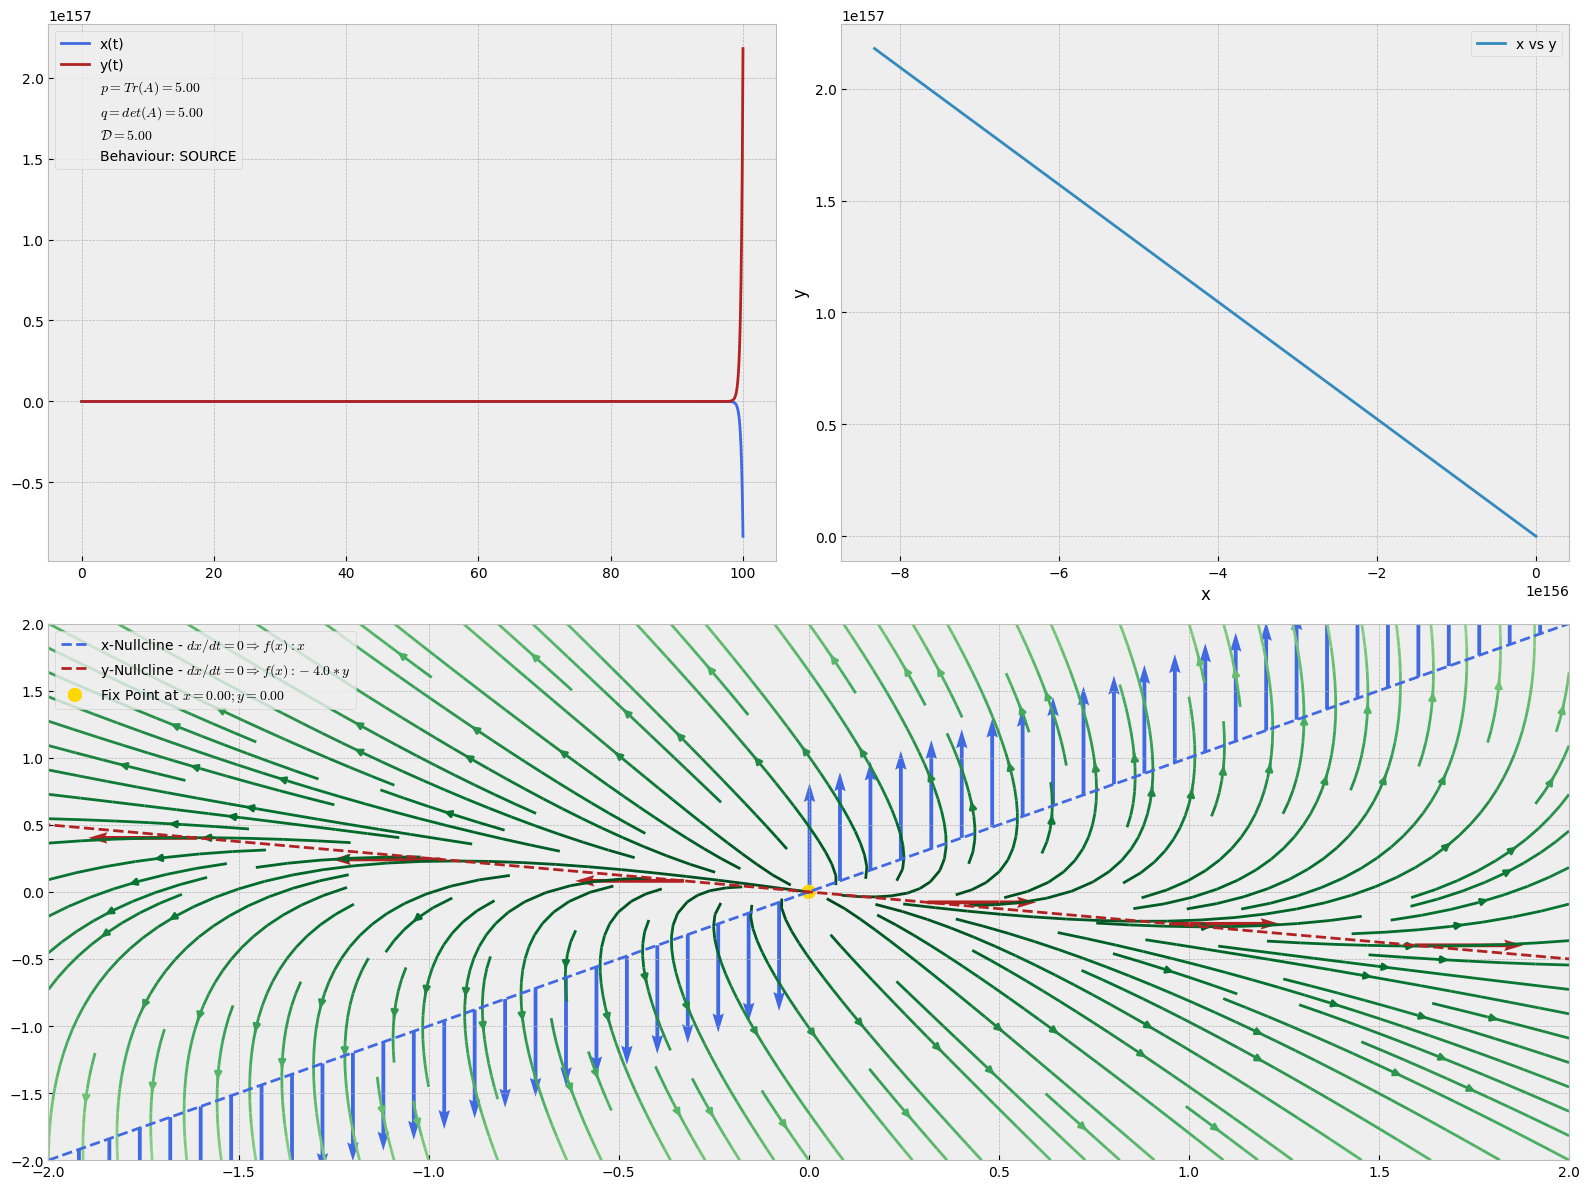

In [28]:
main(
    A=1.0,
    B=-1.00,
    C=1.00,
    D=4.0,
    x_0=1,
    y_0=1,
    days=100,
);

## Sink

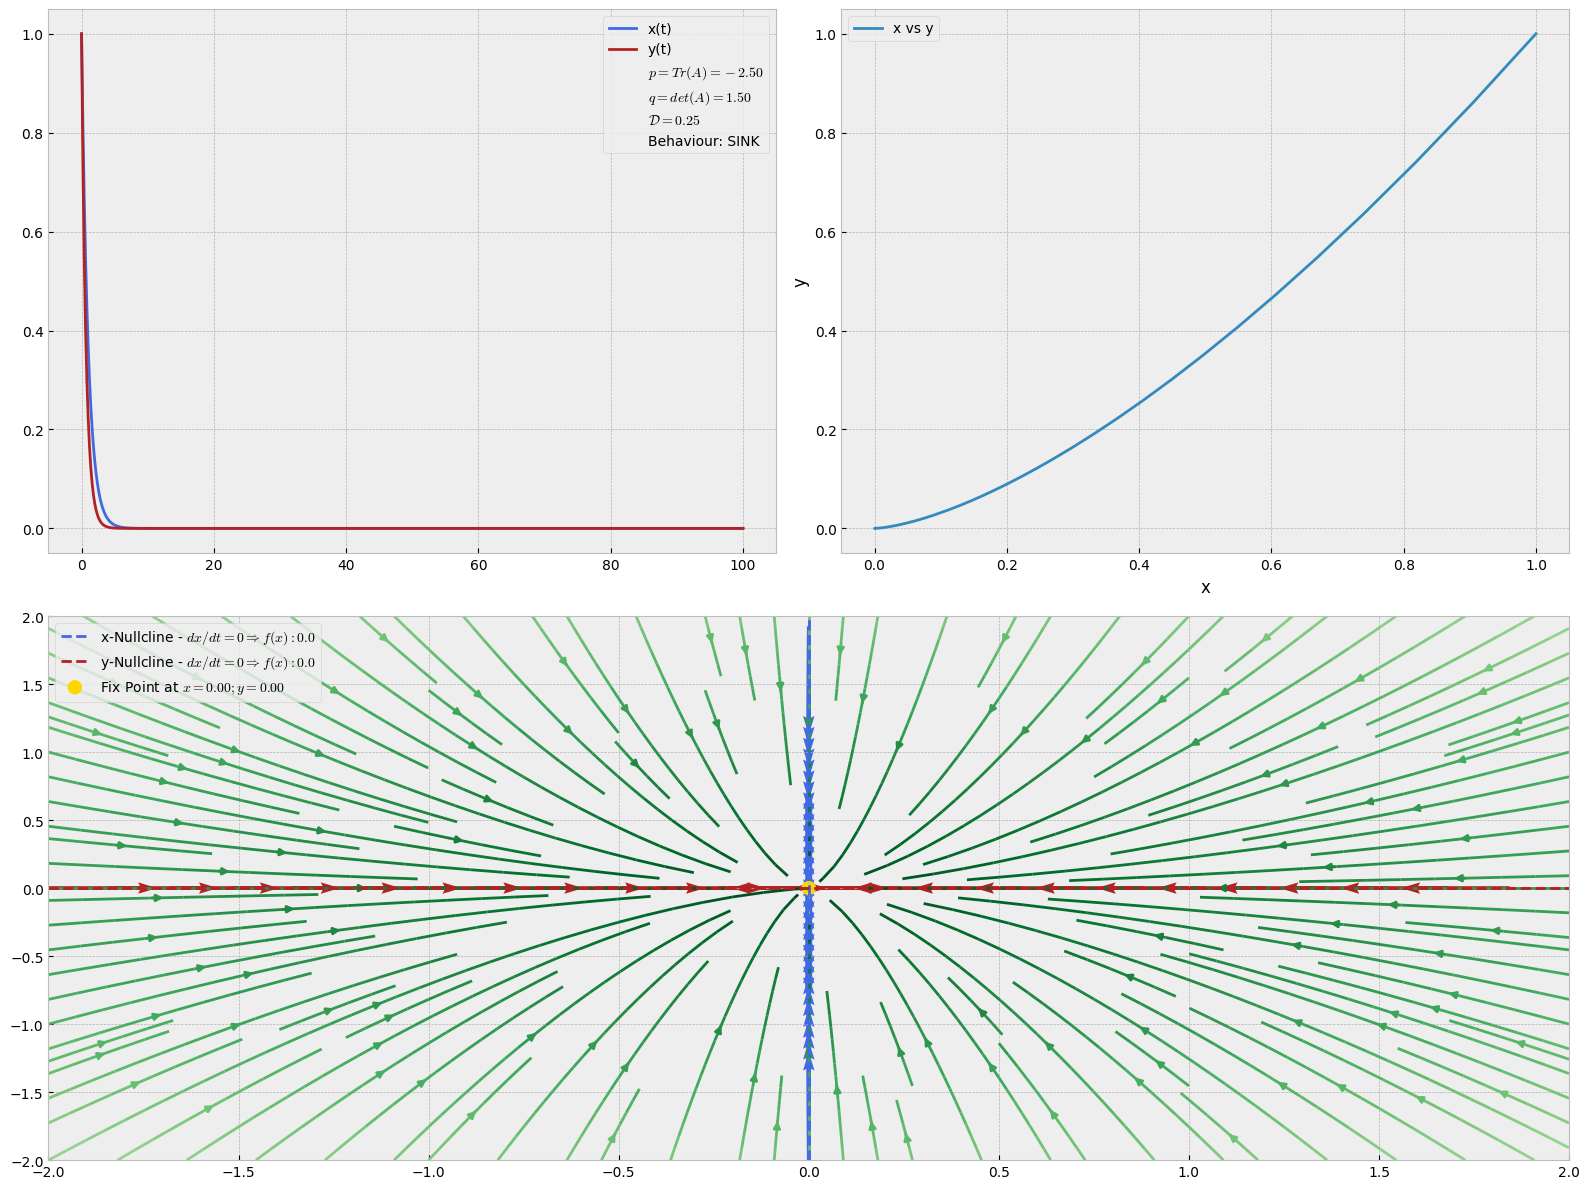

In [21]:
main(
    A=-1.0,
    B=-.00,
    C=0.00,
    D=-1.5,
    x_0=1,
    y_0=1,
    days=100,
);

## Saddle

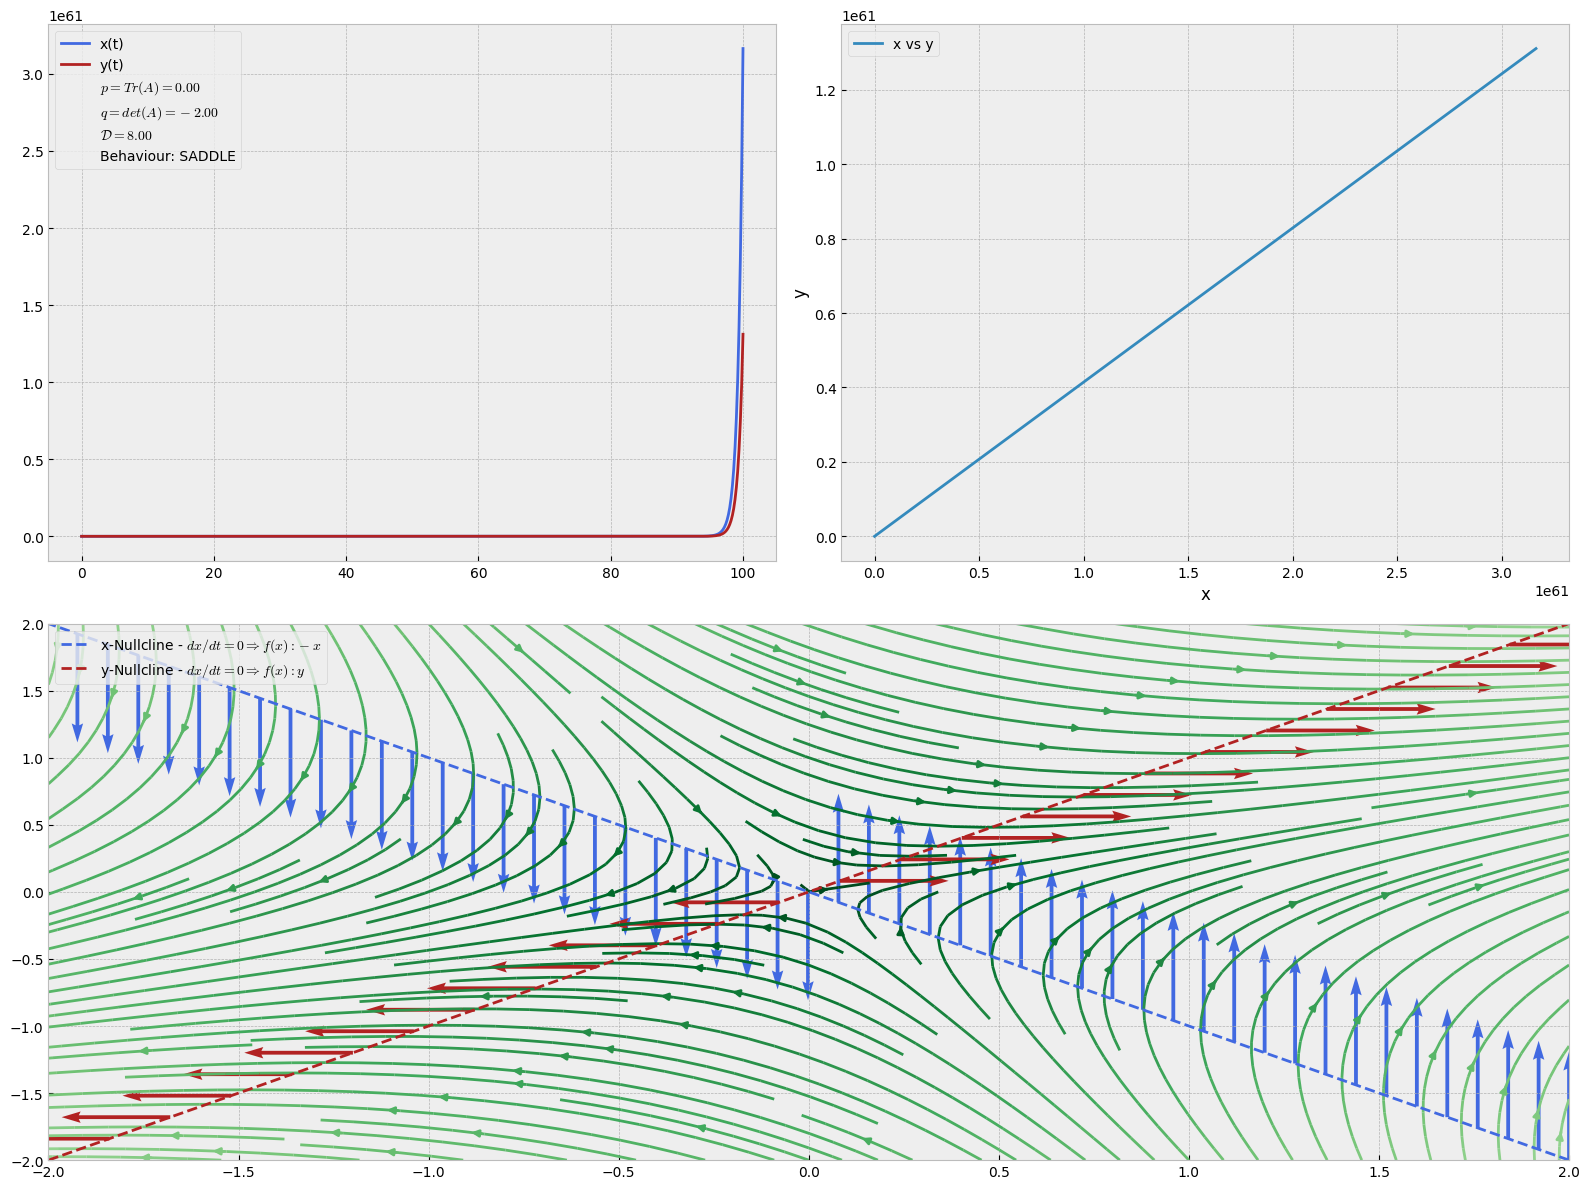

In [59]:
main(
    A=1.0,
    B=1.00,
    C=1.00,
    D=-1.0,
    x_0=1,
    y_0=1,
    days=100,
);

## Center

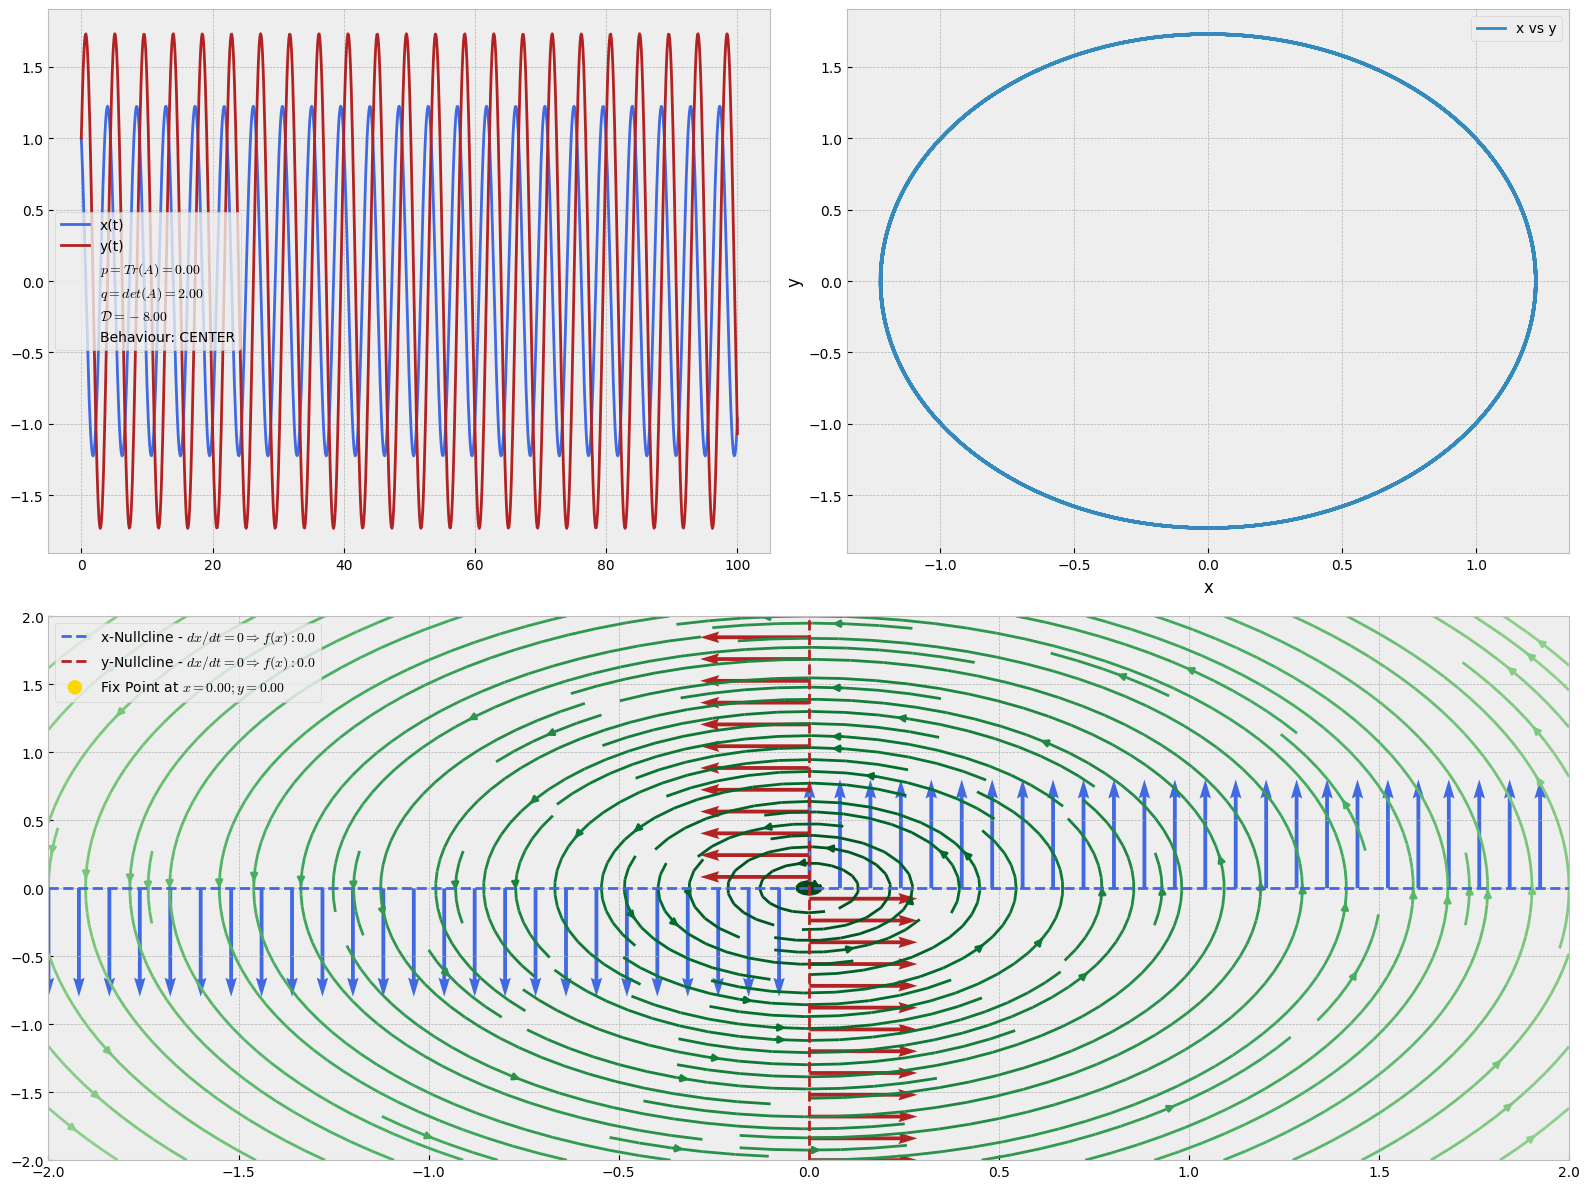

In [15]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=0,
    x_0=1,
    y_0=1,
    days=100,
);

## Spiral Sink

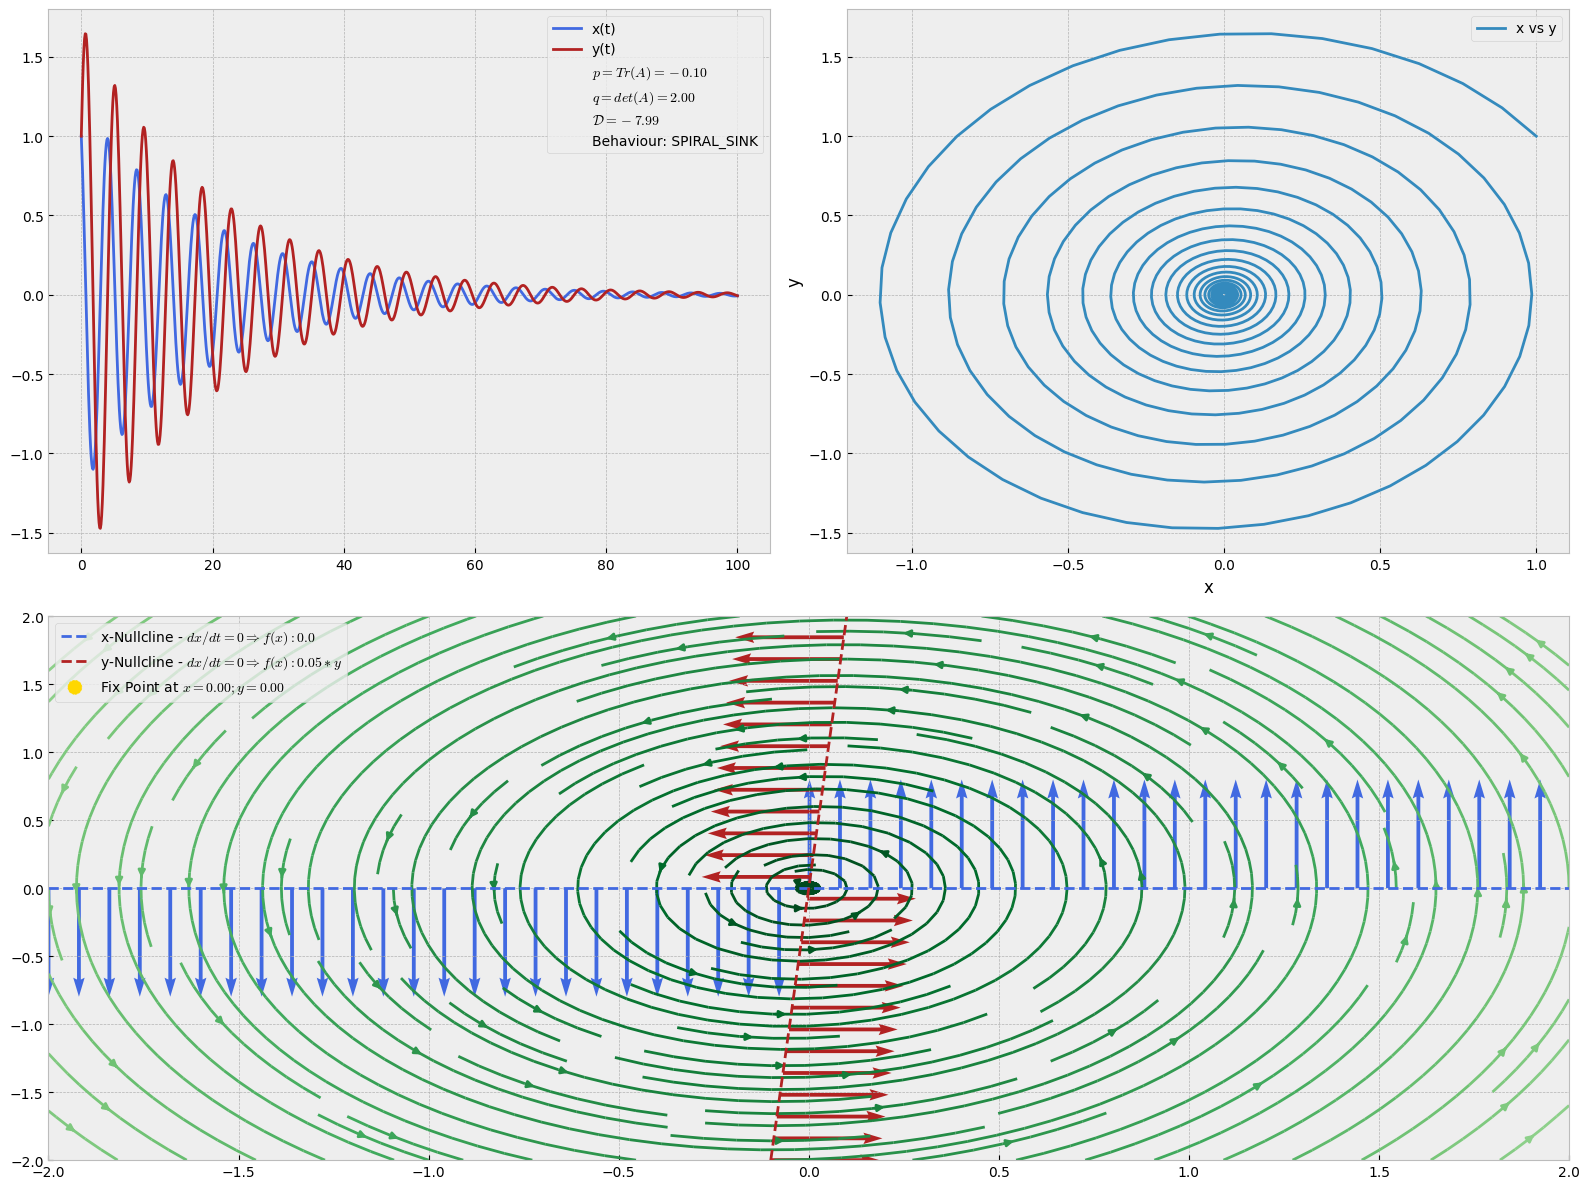

In [14]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=-0.10,
    x_0=1,
    y_0=1,
    days=100,
);

## Spiral Source

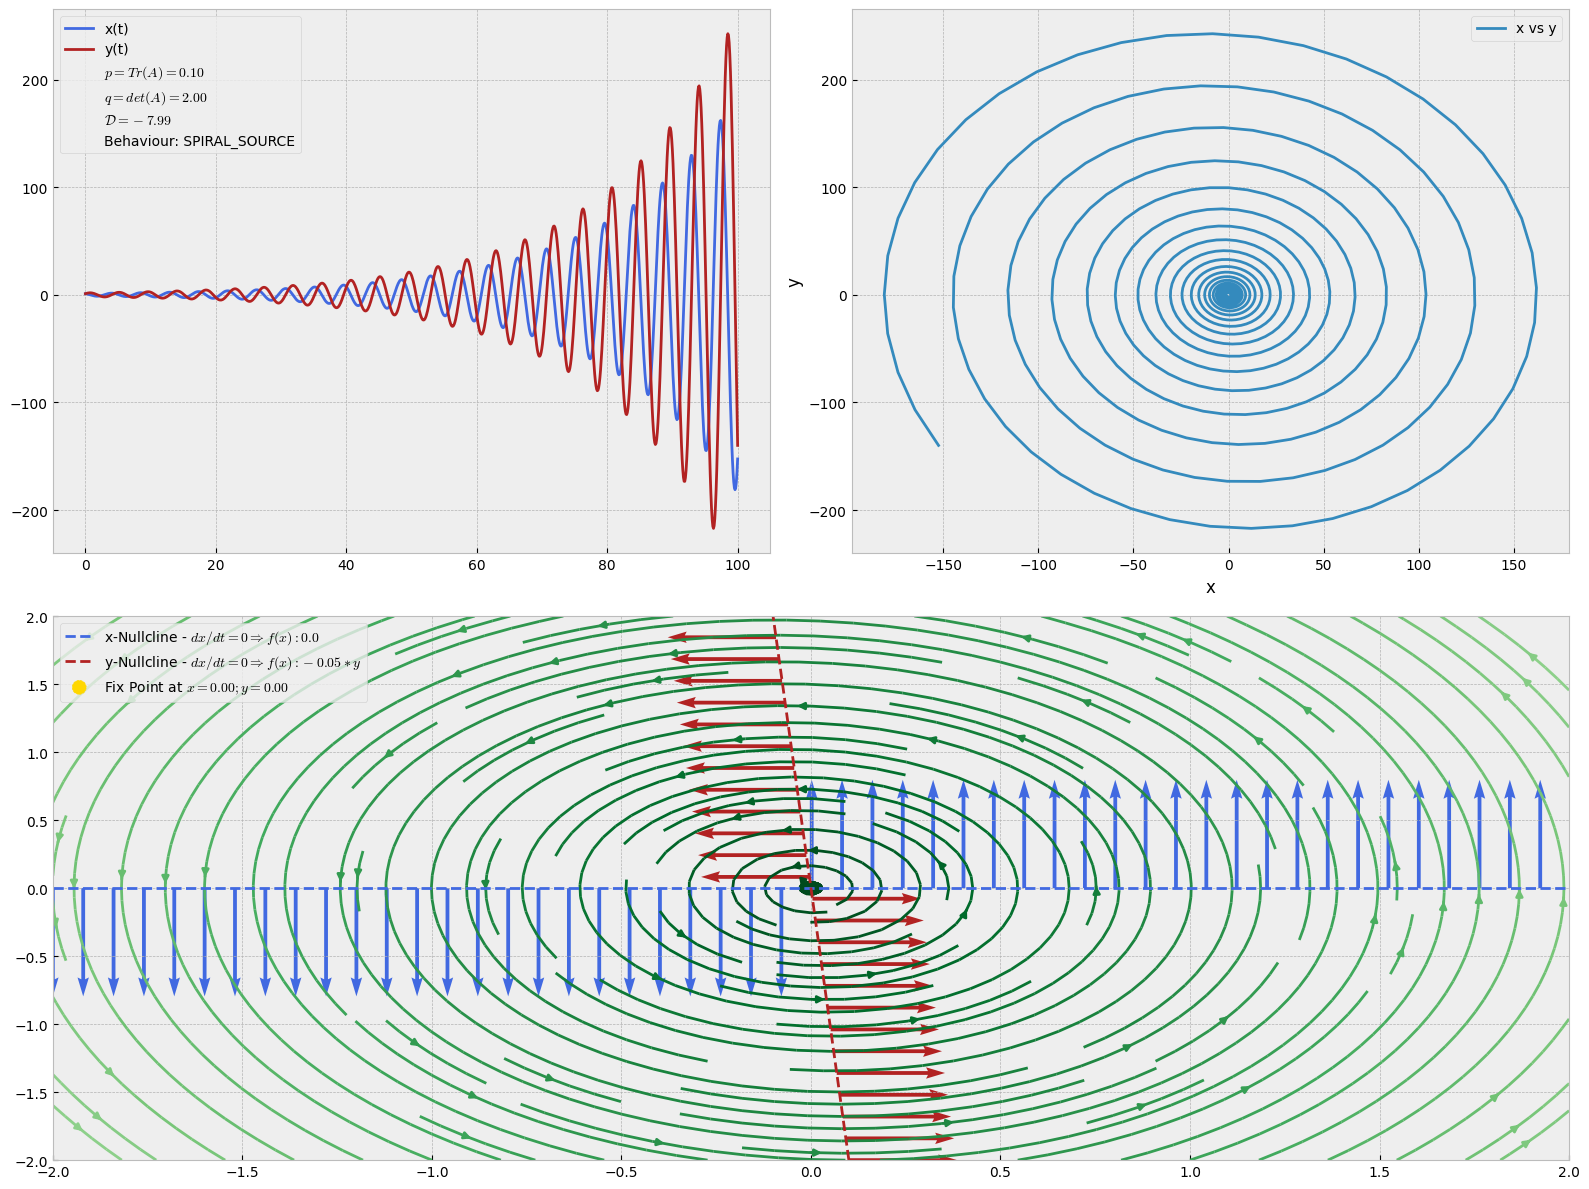

In [16]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=0.10,
    x_0=1,
    y_0=1,
    days=100,
);

# Non-Hyperbolic Scenarios

## Degenerate Source

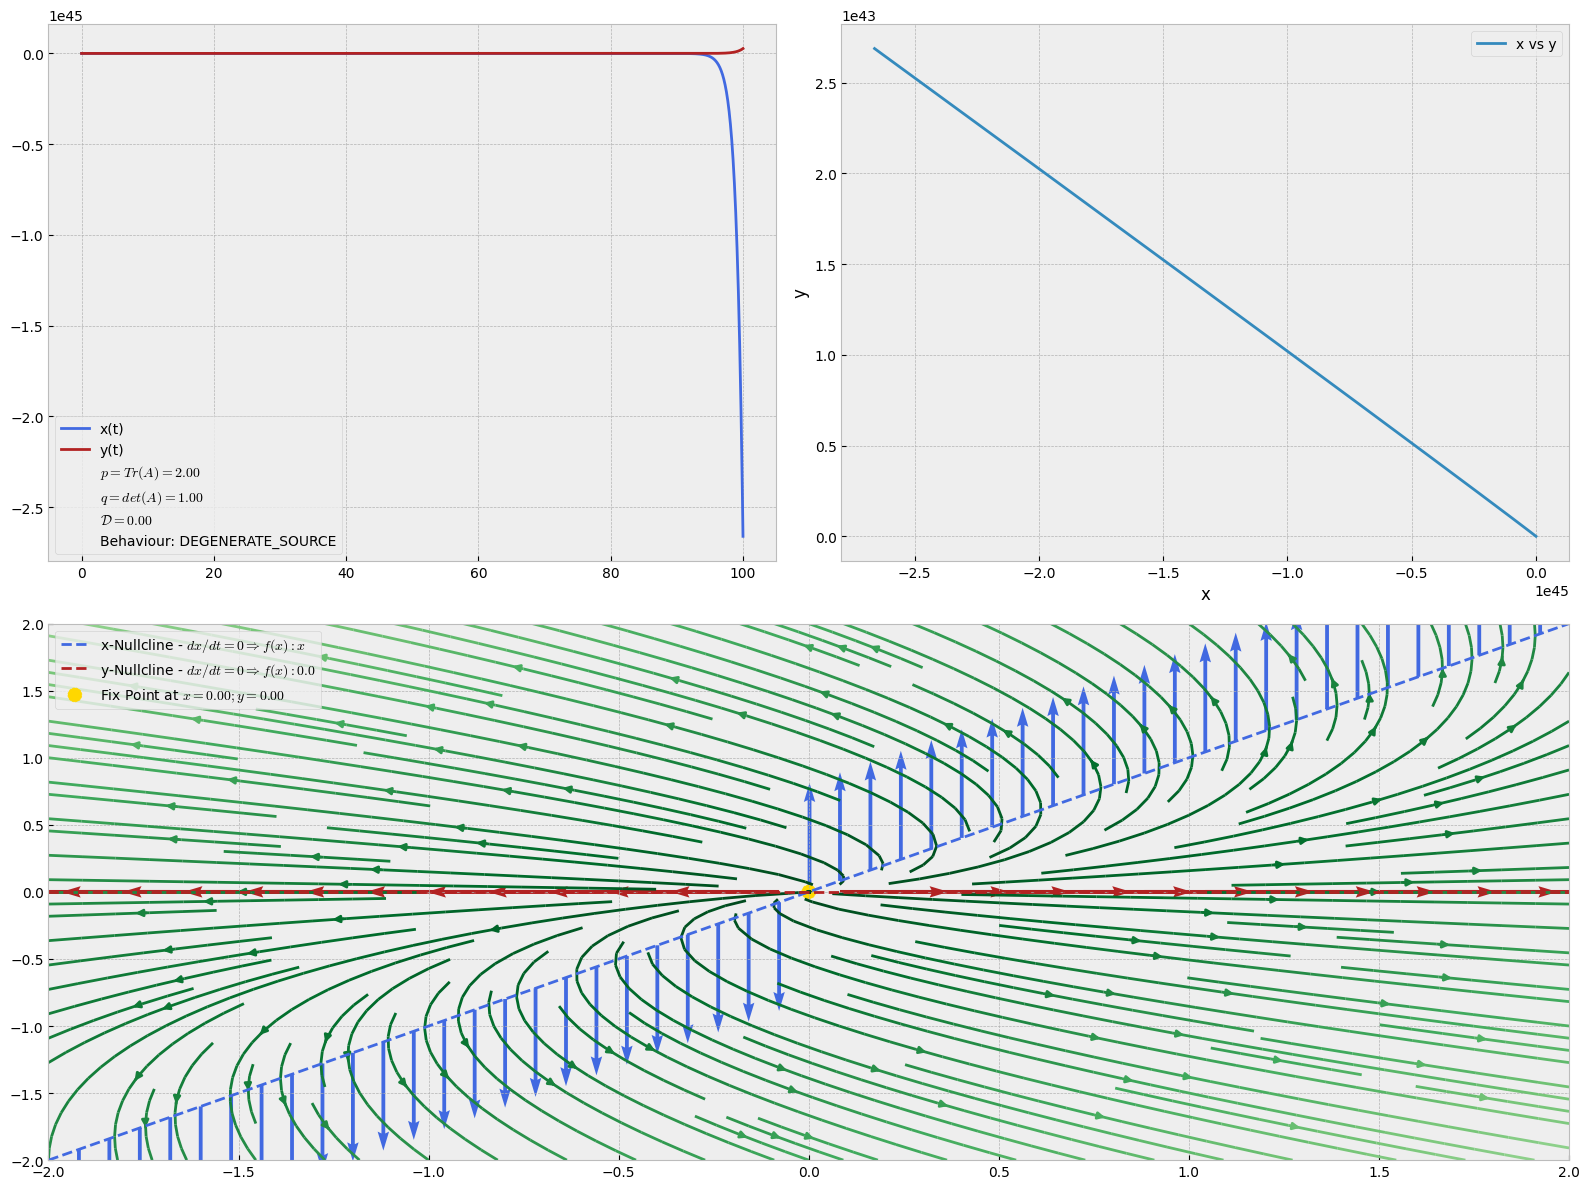

In [17]:
main(
    A=1.0,
    B=-1.00,
    C=0.00,
    D=1.0,
    x_0=1,
    y_0=1,
    days=100,
);

## Degenerate Sink

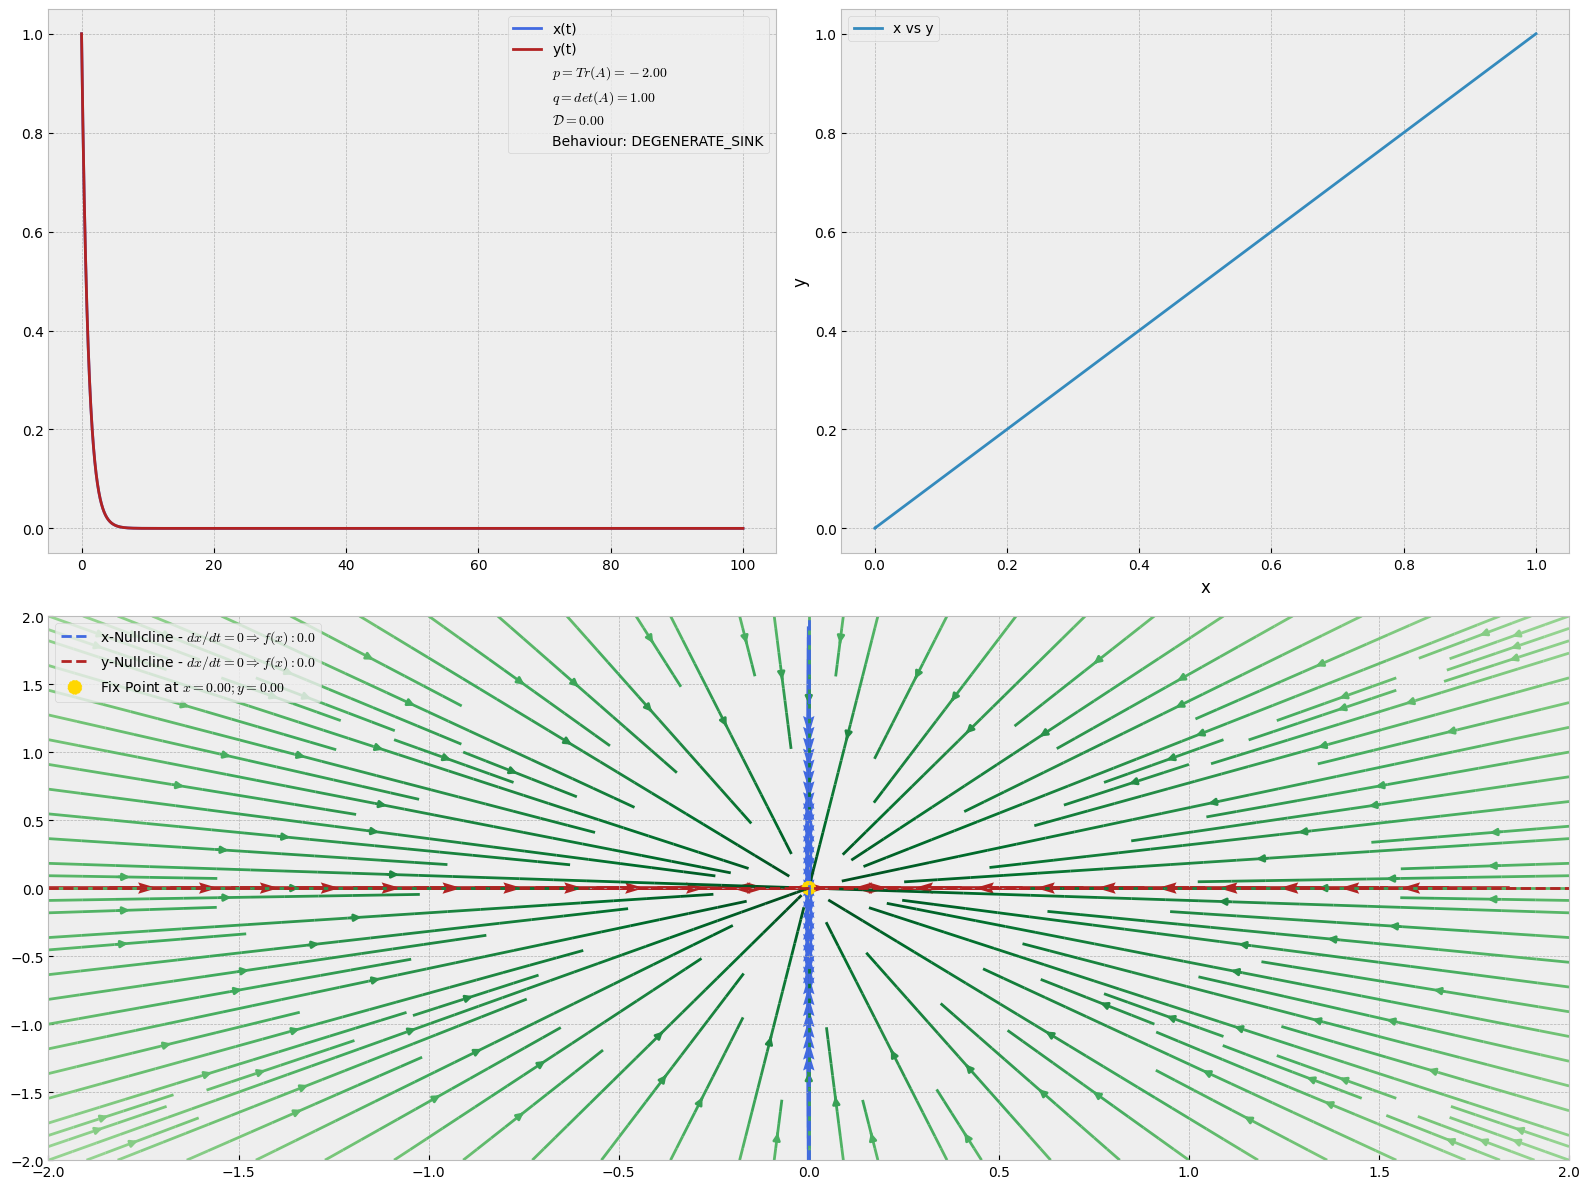

In [18]:
main(
    A=-1.0,
    B=0.00,
    C=0.00,
    D=-1.0,
    x_0=1,
    y_0=1,
    days=100,
);

## Uniform Motion

### On both variables

#### Stable

##### Same Direction

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


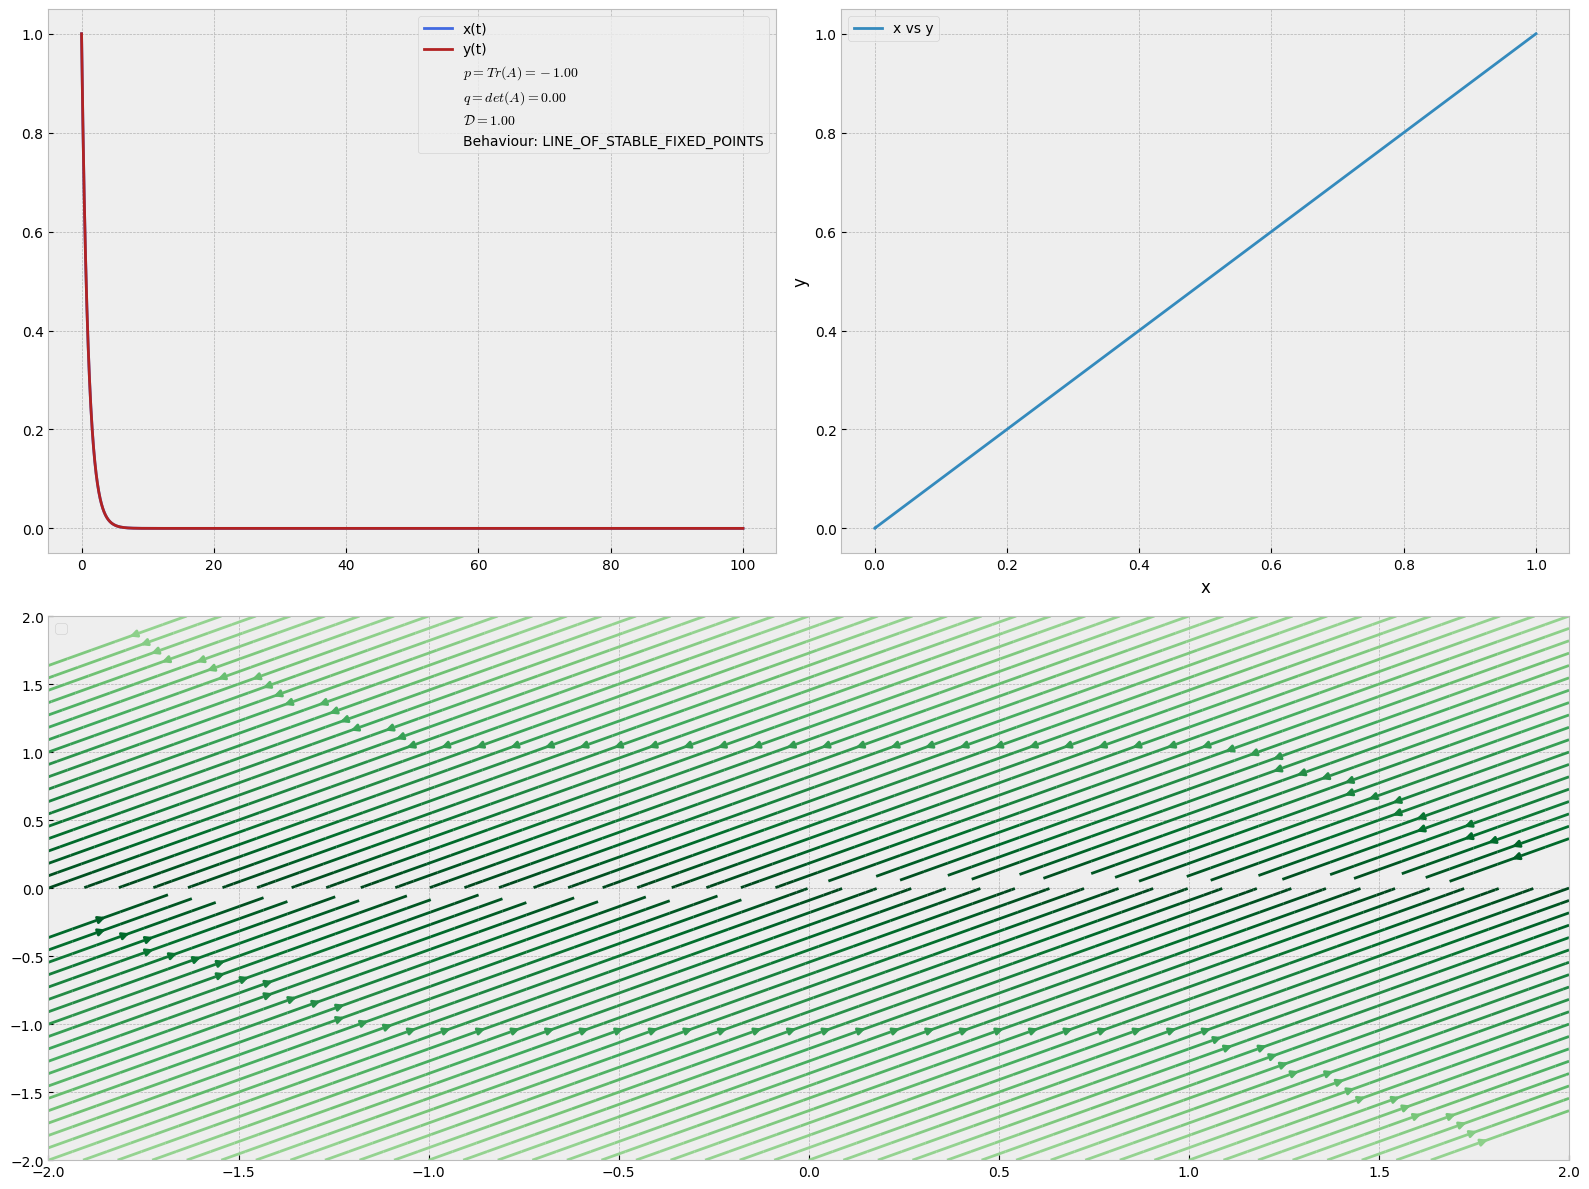

In [64]:
main(
    A=0.0,
    B=-1.00,
    C=0.00,
    D=-1.0,
    x_0=1,
    y_0=1,
    days=100,
);

##### Different Direction

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


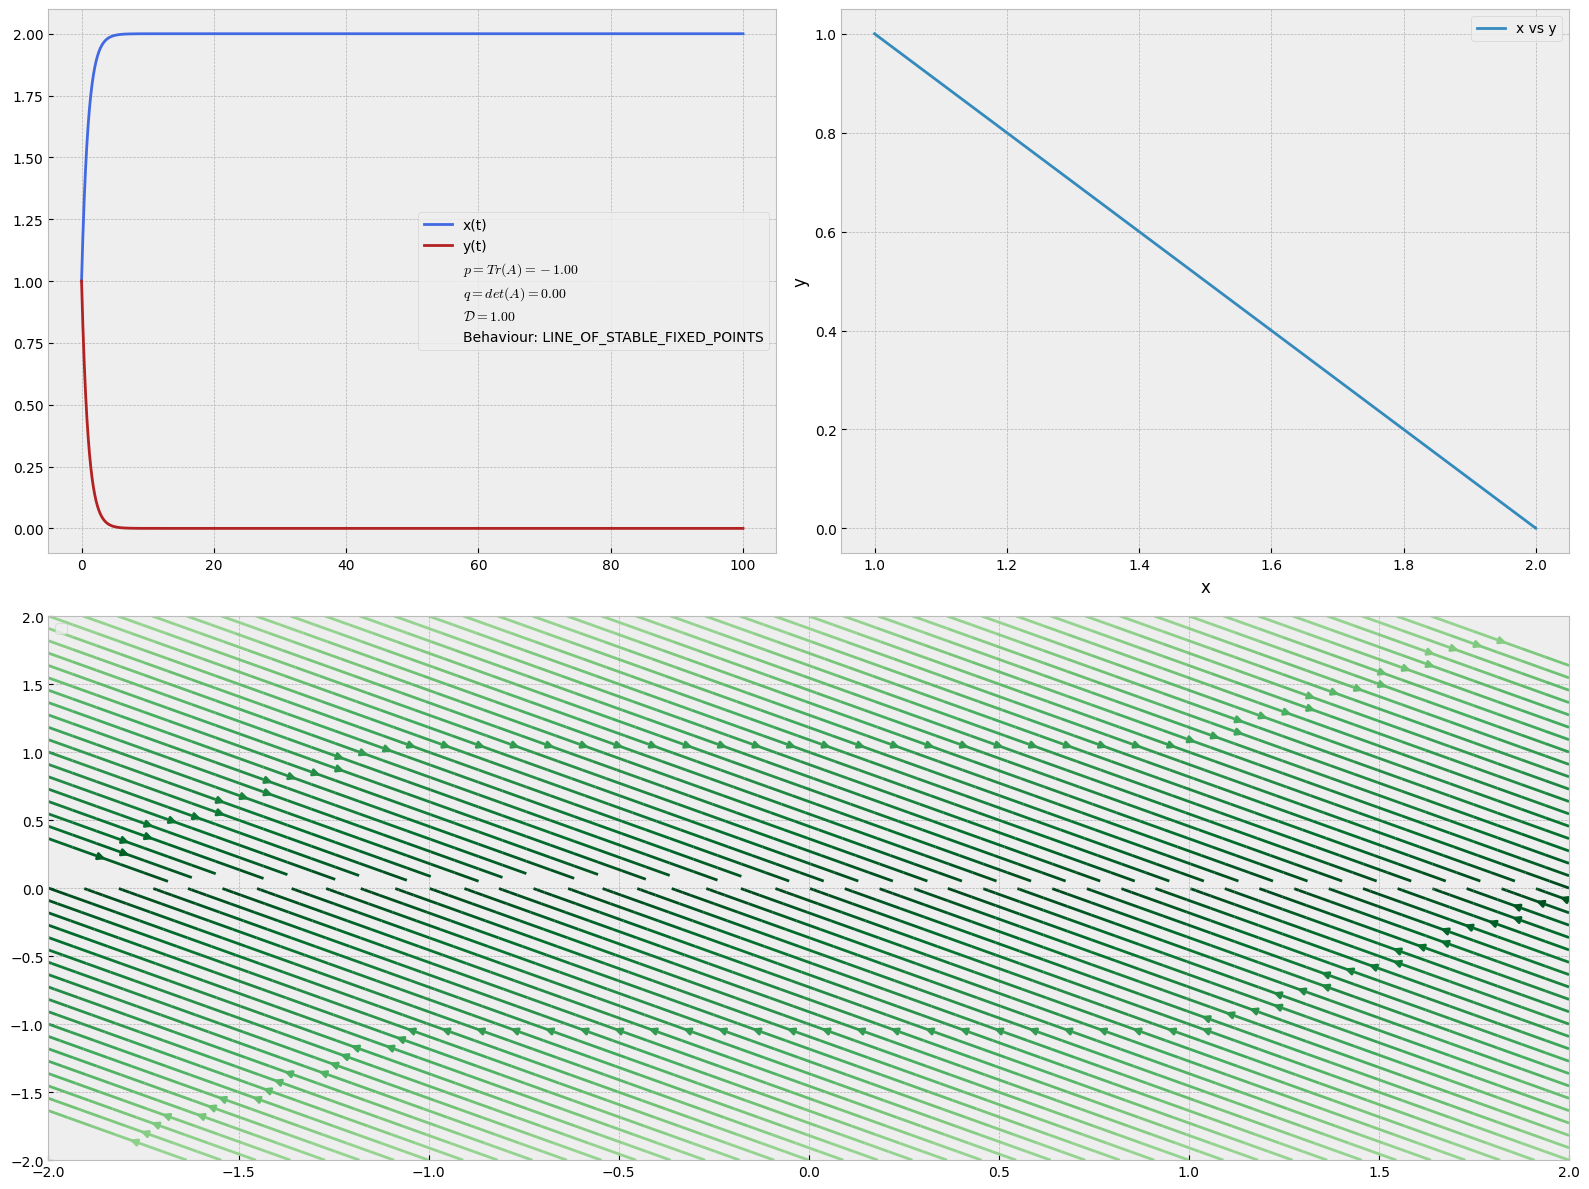

In [63]:
main(
    A=0.0,
    B=1.00,
    C=0.00,
    D=-1.0,
    x_0=1,
    y_0=1,
    days=100,
);

#### Unstable

##### Same Direction

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


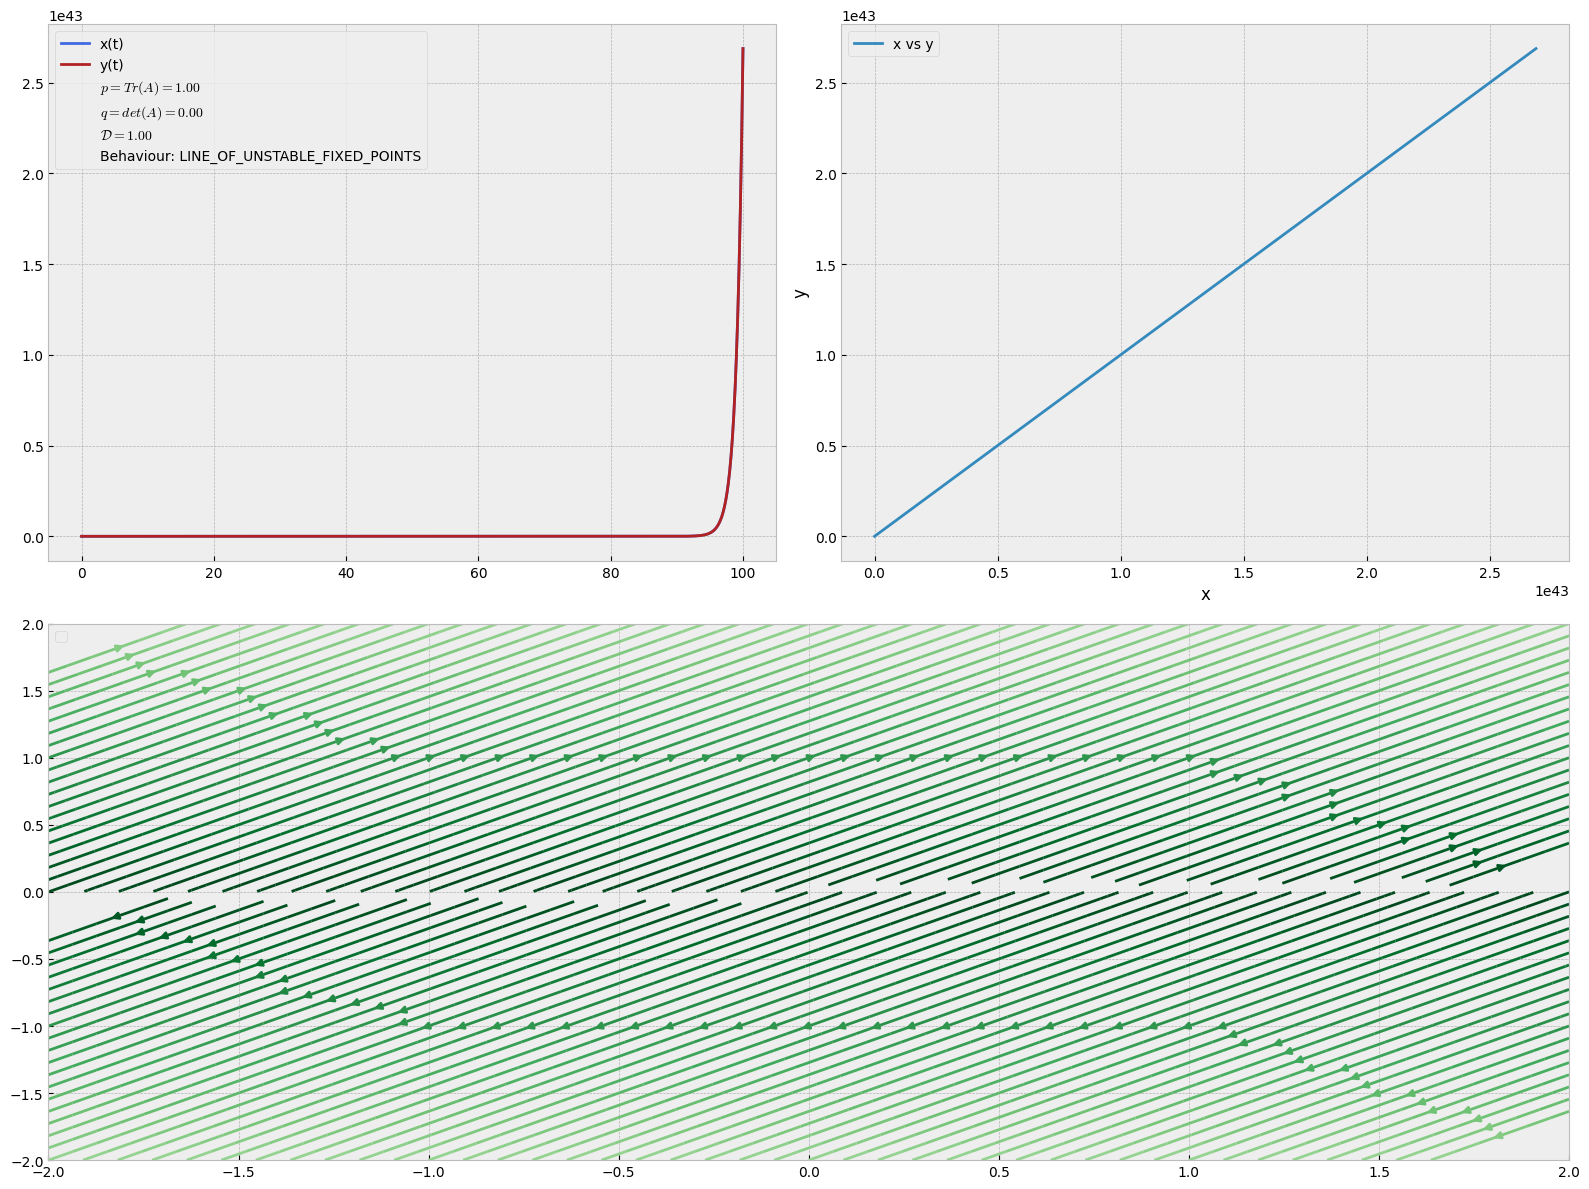

In [61]:
main(
    A=0.0,
    B=1.00,
    C=0.00,
    D=1.0,
    x_0=1,
    y_0=1,
    days=100,
);

##### Different Direction

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


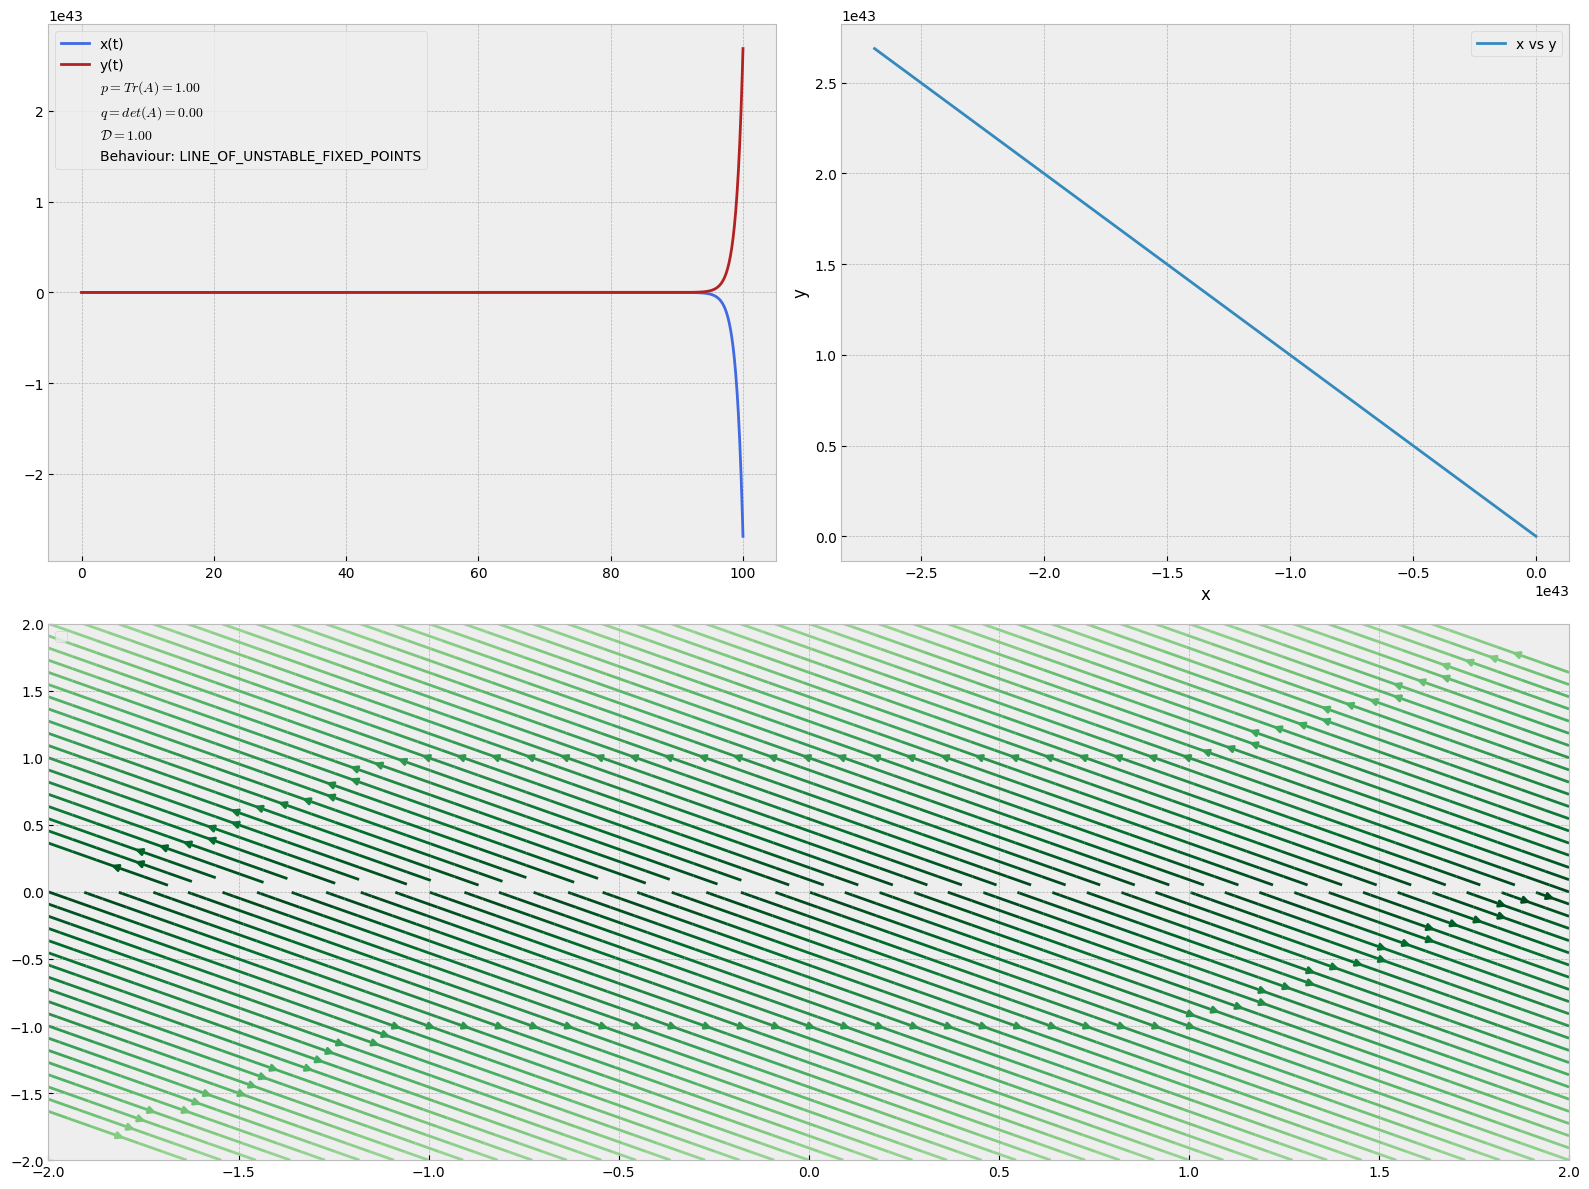

In [67]:
main(
    A=0.0,
    B=-1.00,
    C=0.00,
    D=1.0,
    x_0=1,
    y_0=1,
    days=100,
);

### On a single variable

#### Stable

##### Over X

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


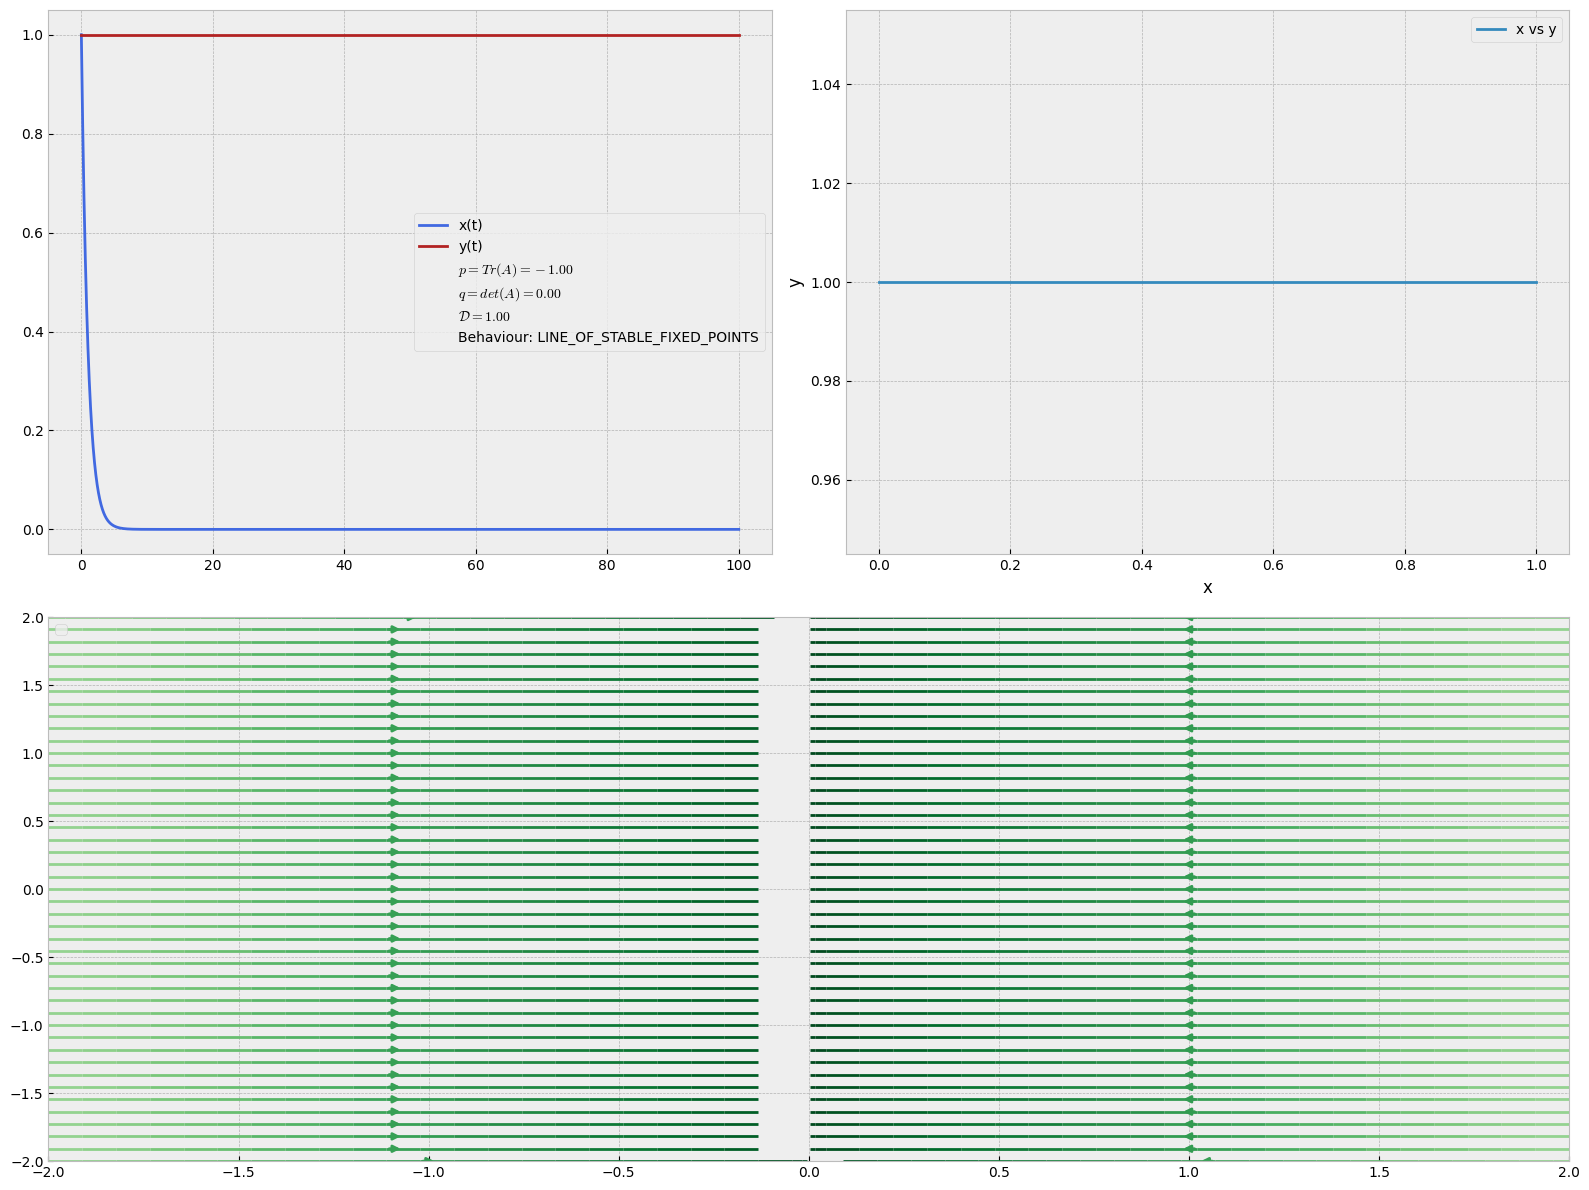

In [56]:
main(
    A=-1.0,
    B=0.00,
    C=0.00,
    D=0.0,
    x_0=1,
    y_0=1,
    days=100,
);

##### Over Y

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


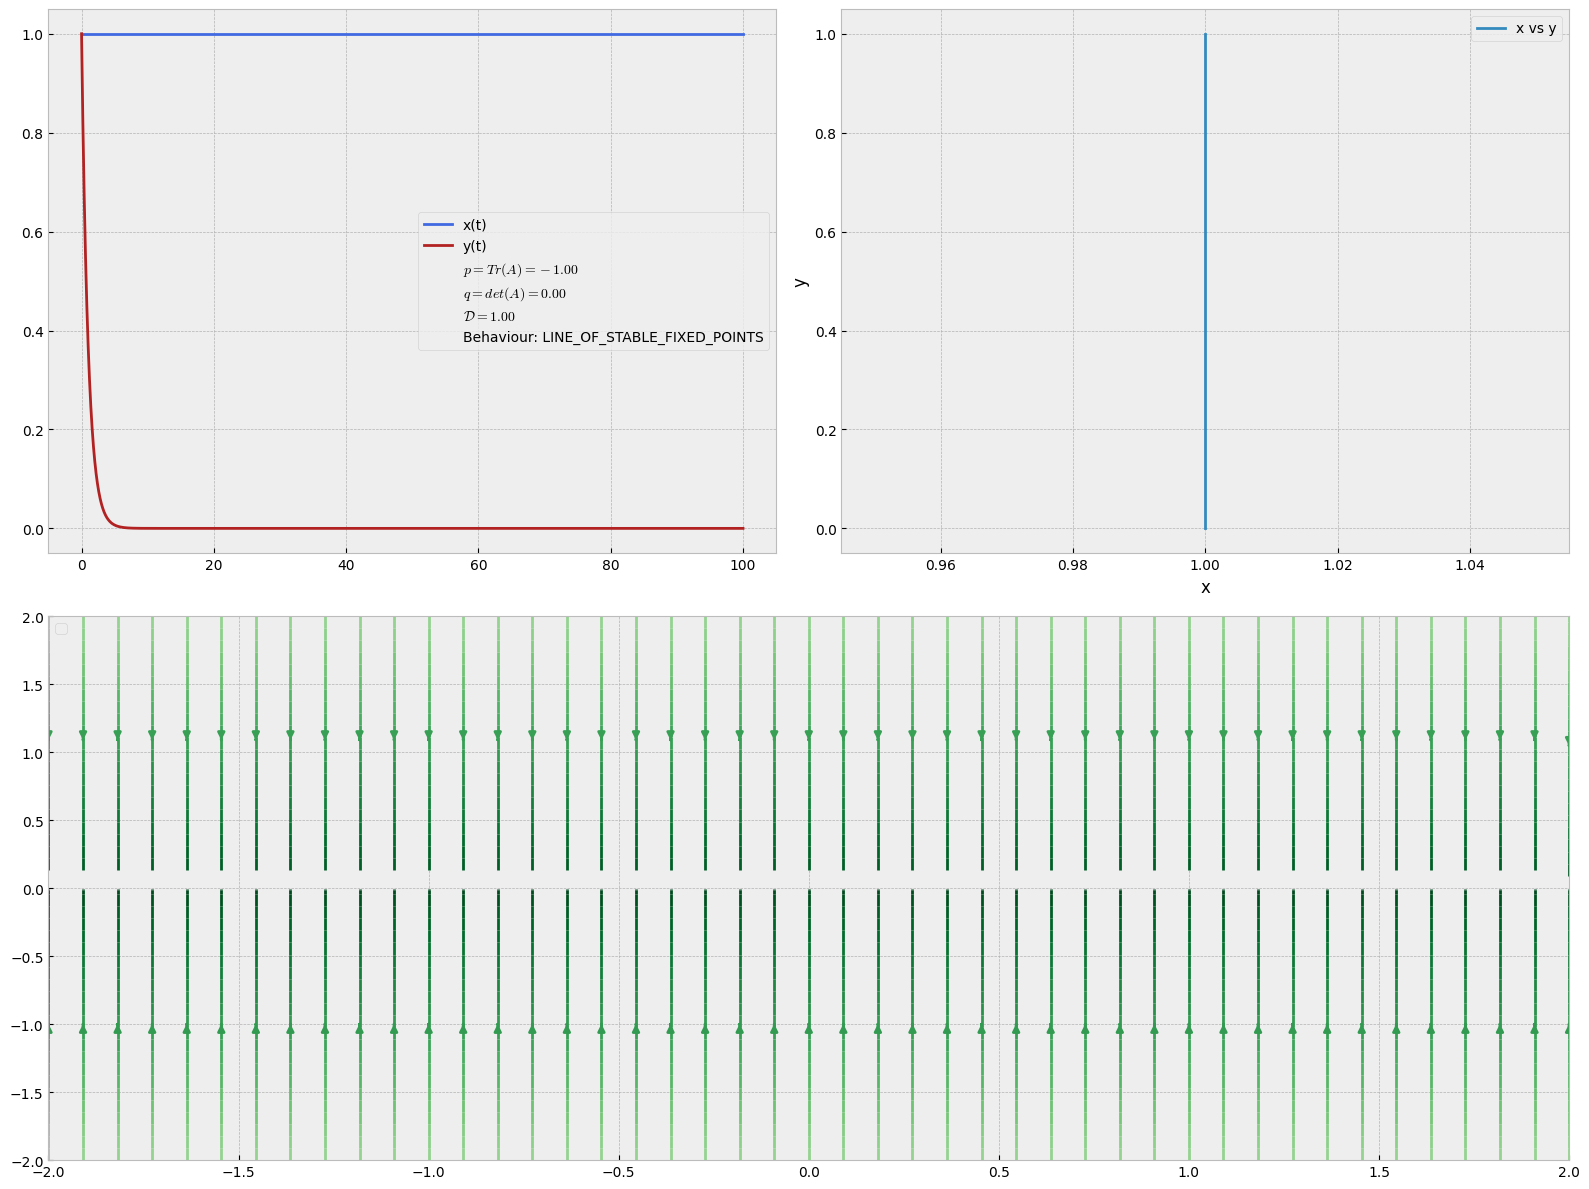

In [57]:
main(
    A=0.0,
    B=0.00,
    C=0.00,
    D=-1.0,
    x_0=1,
    y_0=1,
    days=100,
);

#### Unstable

##### Over X

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


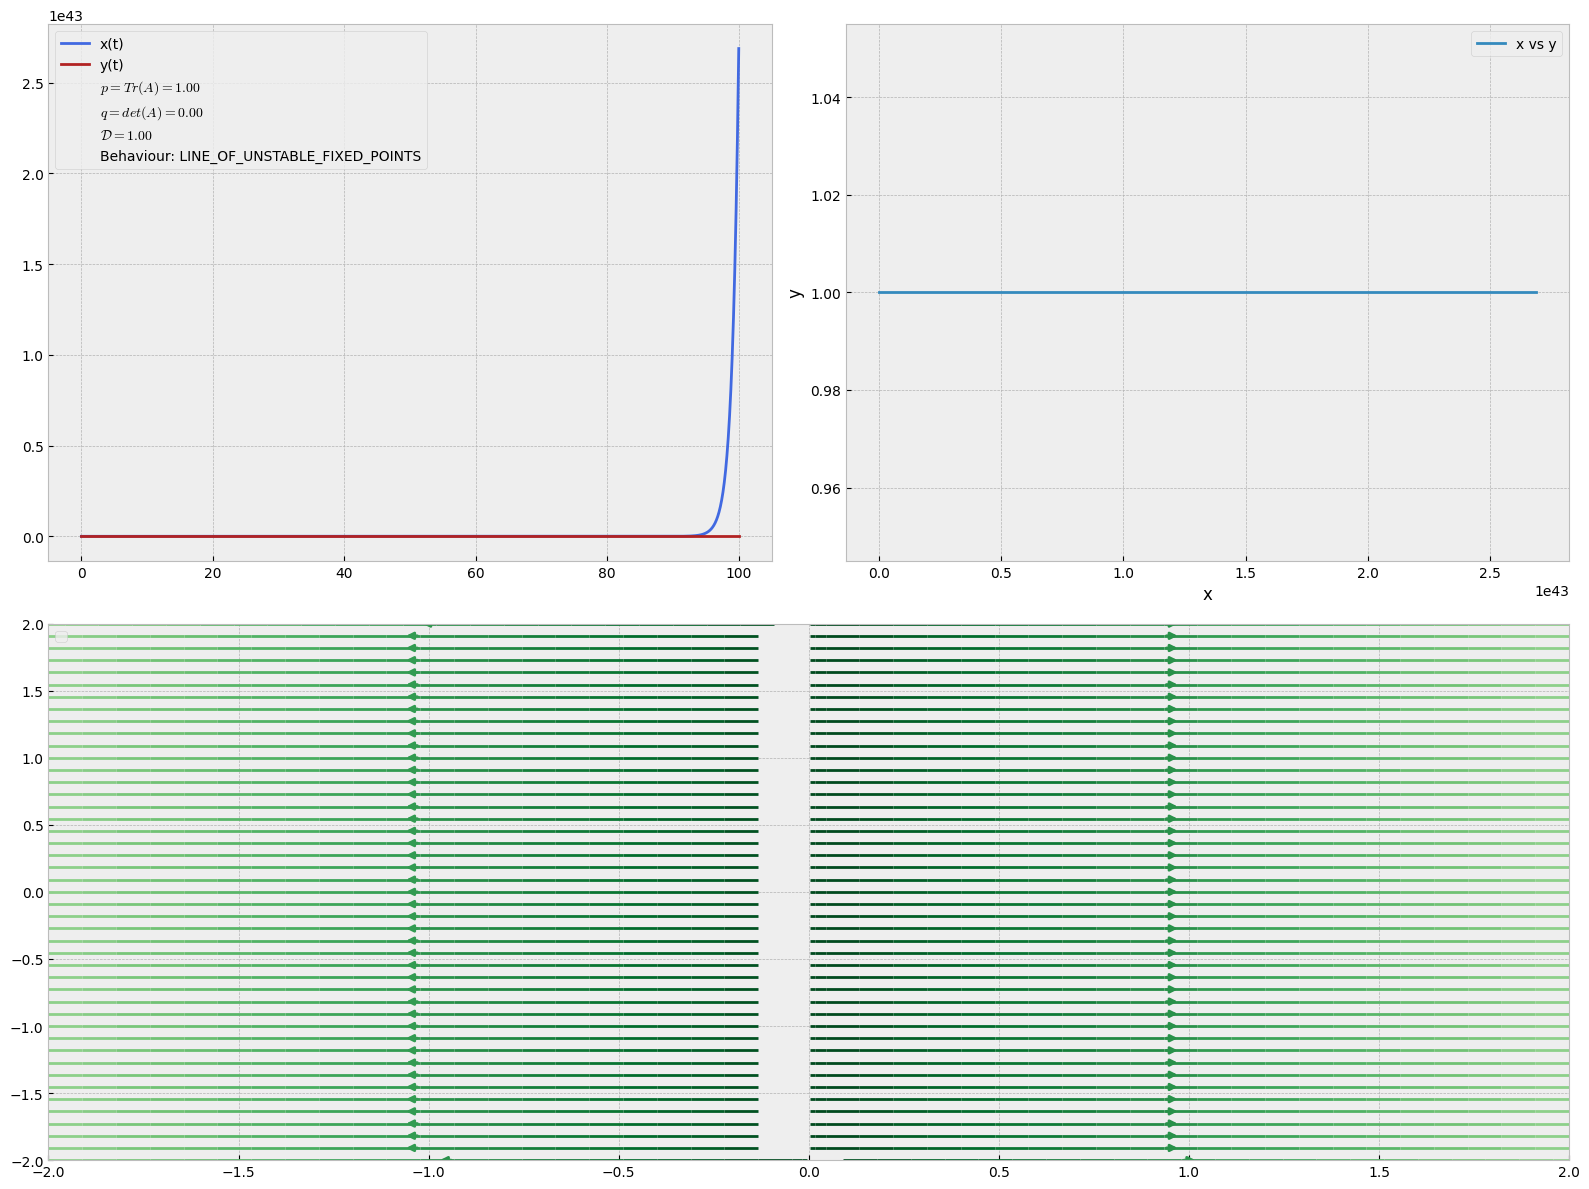

In [53]:
main(
    A=1.0,
    B=0.00,
    C=0.00,
    D=0.0,
    x_0=1,
    y_0=1,
    days=100,
);

##### Over Y

C:\Users\elcg\AppData\Local\Temp\ipykernel_17516\3897367782.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


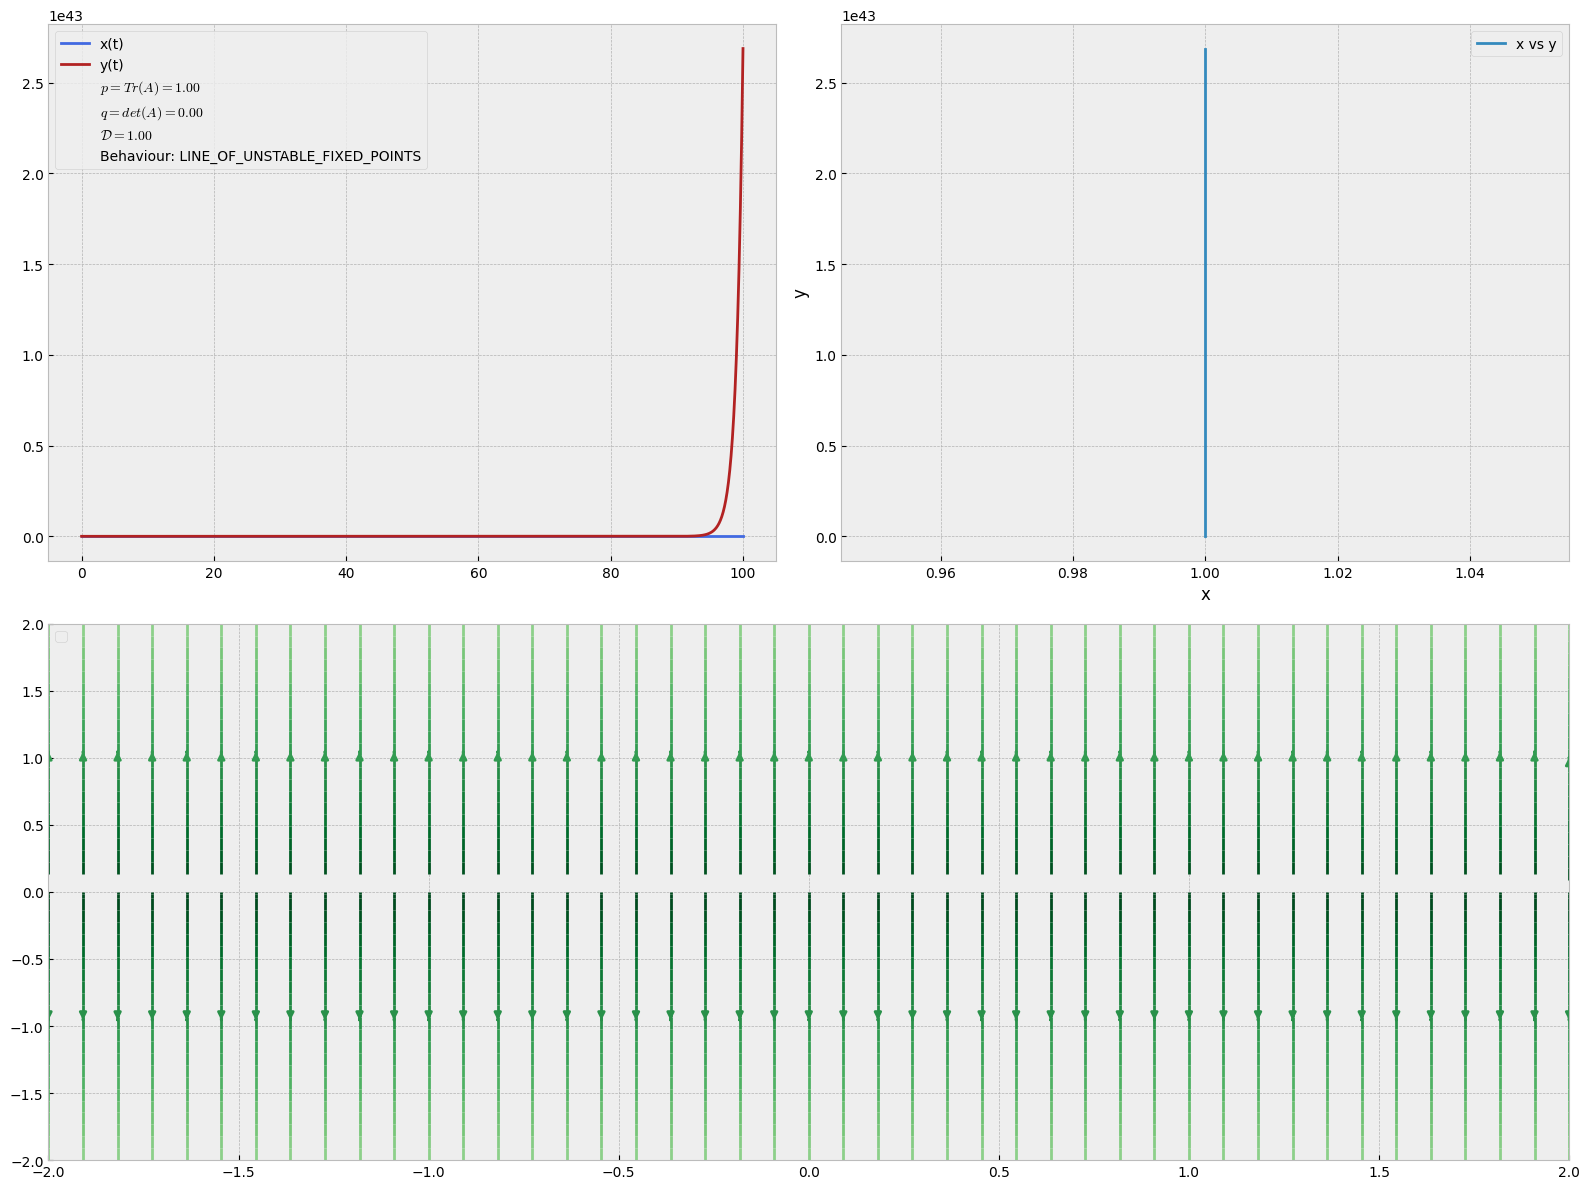

In [55]:
main(
    A=0.0,
    B=0.00,
    C=0.00,
    D=1.0,
    x_0=1,
    y_0=1,
    days=100,
);